<a href="https://colab.research.google.com/github/mohmaed7777/Simple-system-application-of-road-surveillance/blob/main/Simple_system_application_of_road_surveillance.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Import Libraries:=**

In [ ]:
import torch
import fastai
from fastai.basics import *
from fastai.callback.all import *
from fastai.vision.all import *

# **About the dataset:**

**CAMVID, which is a segmentation based dataset from cameras on cars to segment various areas of the road.**

In [ ]:
path = untar_data(URLs.CAMVID)

# **Initialization path for the dataset:**

In [ ]:
path.ls()

(#5) [Path('/root/.fastai/data/camvid/images'),Path('/root/.fastai/data/camvid/models'),Path('/root/.fastai/data/camvid/valid.txt'),Path('/root/.fastai/data/camvid/codes.txt'),Path('/root/.fastai/data/camvid/labels')]

**The validation set is indside a text documents called valid.txt and split by new lines.**

**Read the validation files:**

In [ ]:
valid_fnames = (path/'valid.txt').read_text().split('\n')

In [ ]:
valid_fnames[:5]

['0016E5_07959.png',
 '0016E5_07961.png',
 '0016E5_07963.png',
 '0016E5_07965.png',
 '0016E5_07967.png']

**Display an image and check out how everything aligns up:-**

In [ ]:
path_im = path/'images'
path_lbl = path/'labels'

In [ ]:
fnames = get_image_files(path_im)
lbl_names = get_image_files(path_lbl)

<Axes: >

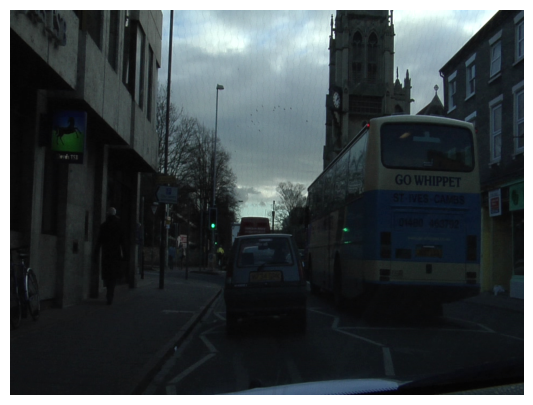

In [ ]:
img_fn = fnames[10]
img = PILImage.create(img_fn)
img.show(figsize=(8,5))

***We need a split functionthat will split from our list of valid filenames are grabbed eariler.**

In [ ]:
def ListSplitter(valid_items):
    def _inner(items):
        val_mask = tensor([o.name in valid_items for o in items])
        return [~val_mask,val_mask]
    return _inner

**Now let's grab our y values(targets). They are founded in the labels folder and are denoted by a _P.**

In [ ]:
get_msk = lambda o:path/'labels'/f'{o.stem}_P{o.suffix}'

**The stem and suffix grap everything before and after the period respectively.**

**Our masks are of type PILMask and we will make our gradient percentage (alph) equal to 1 as we are not overlaying this on anything yet.**

<Axes: >

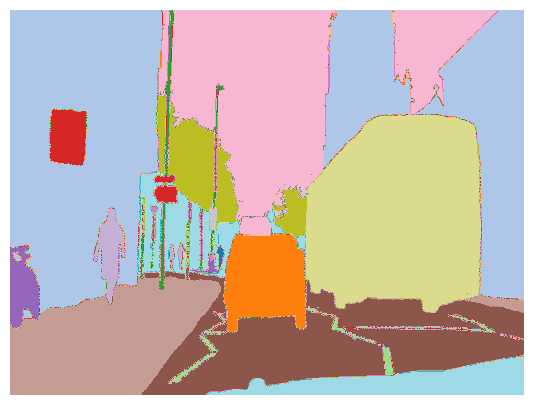

In [ ]:
msk = PILMask.create(get_msk(img_fn))
msk.show(figsize=(8,5), alpha=1)

In [ ]:
codes = np.loadtxt(path/'codes.txt', dtype=str)

# **Create DataBlock and Dataloaders:**

In [ ]:
camvid = DataBlock(blocks=(ImageBlock, MaskBlock(codes)),
                   get_items=get_image_files,
                   splitter=ListSplitter(valid_fnames),
                   get_y=lambda o: path/'labels'/f'{o.stem}_P{o.suffix}',
                   batch_tfms=[*aug_transforms(size=(360,480)), Normalize.from_stats(*imagenet_stats)])

dls = camvid.dataloaders(path/"images", bs=8)

In [ ]:
dls = SegmentationDataLoaders.from_label_func(path, bs=8,
    fnames = get_image_files(path/"images"),
    label_func = lambda o: path/'labels'/f'{o.stem}_P{o.suffix}',
    codes = codes,
    batch_tfms=[*aug_transforms(size=(360,480)), Normalize.from_stats(*imagenet_stats)])

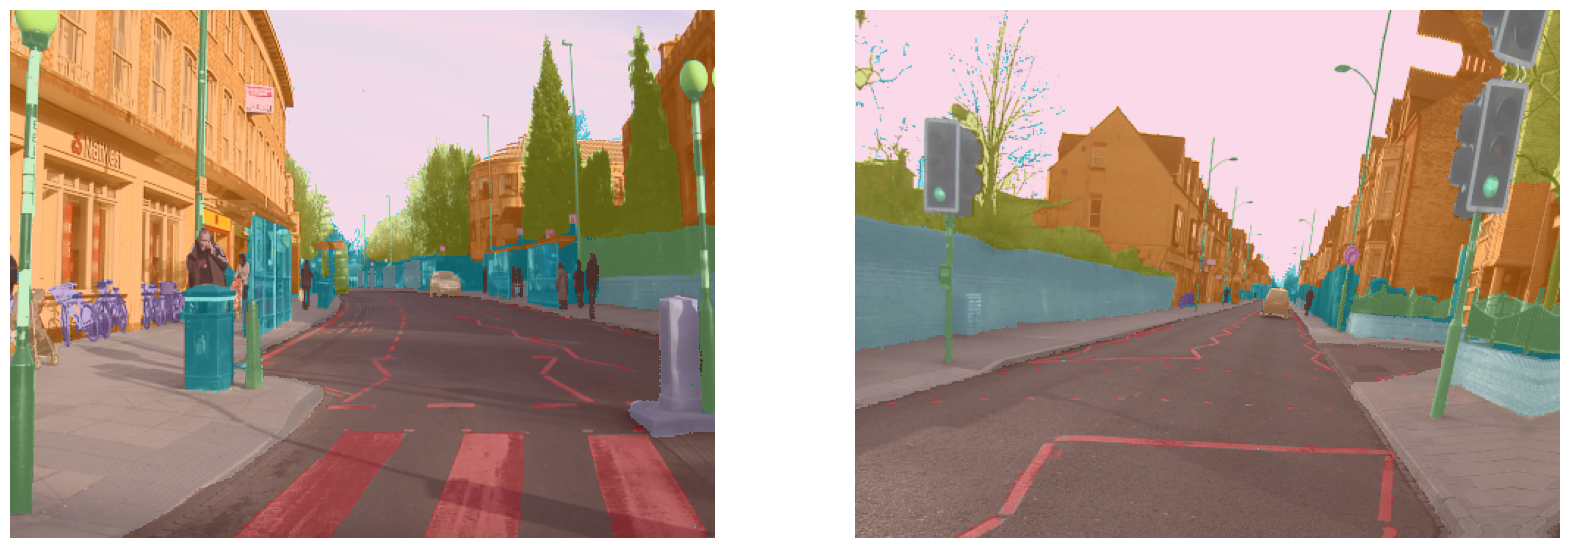

In [ ]:
dls.show_batch(max_n=2, figsize=(20, 7))

In [ ]:
codes = np.loadtxt(path/'codes.txt', dtype=str)
dls.vocab = codes

# **Create accuracy function:**

**For segmentation, we want to squeeze all the outputted values to have it as a matrix of digits for our segmentation mask. From there, we want to match their argmax to the target's mask for each pixel and take the average.**

In [ ]:
name2id = {v:k for k,v in enumerate(codes)}
void_code = name2id['Void']

def acc_camvid(input, target):
    target = target.squeeze(1)
    mask = target != void_code
    return (input.argmax(dim=1)[mask]==target[mask]).float().mean()

# **Initiate Optimizer and Model Architecture :=**

In [ ]:
opt_func = partial(Adam, lr=3e-3, wd=0.01)#, eps=1e-8)

learn = unet_learner(dls, resnet34, loss_func=CrossEntropyLossFlat(axis=1), opt_func=opt_func, path=path, metrics=acc_camvid,
                     norm_type=None, wd_bn_bias=True)

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 90.3MB/s]


In [ ]:
get_c(dls)

32

# **Find optimum learning rate:=**

SuggestedLRs(valley=0.00013182566908653826)

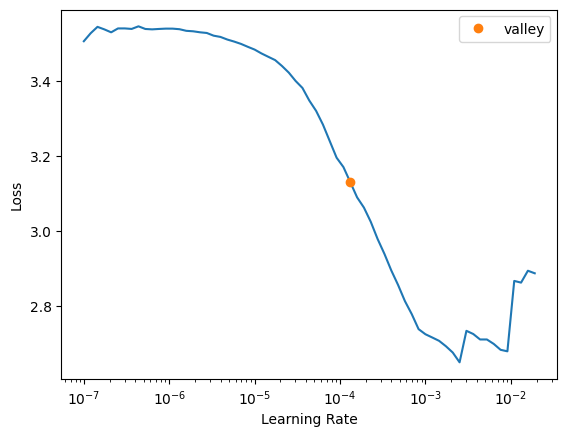

In [ ]:
learn.lr_find()

In [ ]:
lr= 3e-3
learn.freeze()

# **Train the Model:=**

In [ ]:
learn.fit_one_cycle(10, slice(lr), pct_start=0.9, wd=1e-2)

epoch,train_loss,valid_loss,acc_camvid,time
0,1.260670,0.948639,0.772503,00:48
1,0.857016,0.637611,0.839764,00:48
2,0.731077,0.550387,0.859103,00:48
3,0.649547,0.610422,0.851836,00:48
4,0.667692,0.643207,0.846945,00:48
5,0.571126,0.478217,0.879628,00:48
6,0.553029,0.511250,0.870066,00:48
7,1.457709,1.323402,0.599793,00:48
8,1.128022,0.693899,0.836234,00:47
9,0.753410,0.536226,0.863929,00:47


# **Show the results accroding to the actual masks of pictures:=**

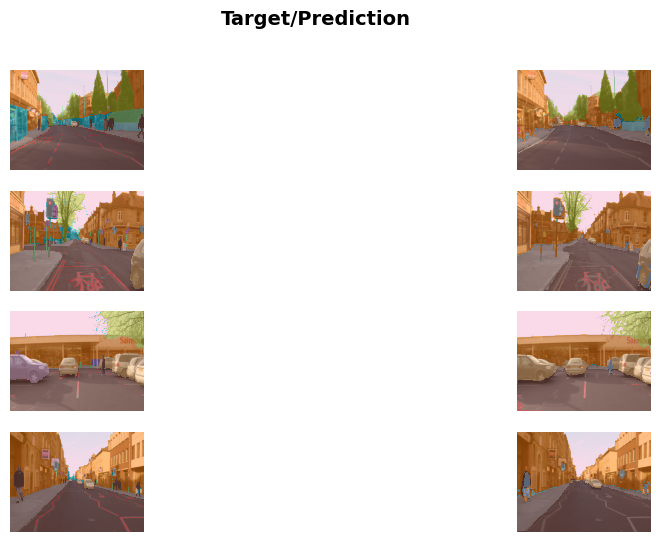

In [ ]:
learn.show_results(max_n=4, figsize=(12,6))
